In [7]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd

cwd = os.getcwd()
if cwd.endswith('notebook/PG'):
    os.chdir('../..')
    cwd = os.getcwd()

from src.pg_modelling.ligand_utils import sanitize_ligand_name, parse_plip_output

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

In [9]:
pg_modelling_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'
data_folder = pg_modelling_folder / 'Lysostaphin_P10547'
assert data_folder.is_dir()

# Lysostaphin SH3b domain

- Bridge crosslink from S. aureus: pentaglycine (main positive control)
- Bridge crosslink from S. aureus: GGSGG (main negative control)
- Bridge crosslink from S. equi: two Alanine (negative control)
- Direct crosslink from E. coli (negative control)
- Any odd lipid in the same molecular weight ballpark (negative control)

In [10]:
E_coli_libary = pg_modelling_folder / 'PG_library' / 'Escherichia_coli' / 'E_coli_cell_wall_library.xlsx'
S_equi_libary = pg_modelling_folder / 'PG_library' / 'Streptococcus_equi' / 'S_equi_cell_wall_library.xlsx'
S_aureus_libary = pg_modelling_folder / 'PG_library' / 'Staphylococcus_aureus' / 'S_aureus_cell_wall_library.xlsx'

pg_library = pd.concat(
    [
        pd.read_excel(
            E_coli_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            E_coli_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_equi_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_equi_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=1,
        ),
    ],
    ignore_index=True,
)
pg_library['ligand_id'] = pg_library['Name'].apply(sanitize_ligand_name)
pg_library = pg_library.drop_duplicates('ligand_id')
pg_library = pg_library.set_index('ligand_id')
print(f'N = {len(pg_library):,}')

N = 2,553


In [11]:
subset_ids = [
    'KA-3-NH2-GGGGG-3br-4-qKA',
    'KA-3-NH2-GGSGG-3br-4-qKA',
    'KA-3-NH2-AA-3br-4-qKA',
    'mA-3s-4-emA',
]
pg_library_subset = pg_library.loc[subset_ids].rename(columns={
    'SMILES': 'smiles',
    'Monoisotopic Mass': 'mass',
})[['smiles', 'mass']]
print(f'N = {len(pg_library_subset):,}')
pg_library_subset

N = 4


,smiles,mass
ligand_id,,
KA-3-NH2-GGGGG-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CN...,829.44061
KA-3-NH2-GGSGG-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)CNC(=O)CNC(=O)C(CO)NC(=...,859.45118
KA-3-NH2-AA-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C...,686.40752
mA-3s-4-emA,CC(NC(=O)C(N)CCCC(NC(=O)C(C)NC(=O)C(CCCC(N)C(=...,633.29697


In [12]:
# Pick larg-ish lipid from E. coli: (3S)-citryl-CoA
lipid_maps = pd.read_csv(pg_modelling_folder / 'PG_library' / 'lipid_maps' / 'lipids.csv')
lipid_df = lipid_maps[lipid_maps['NAME'] == '(3S)-citryl-CoA'].copy()
lipid_df['ligand_id'] = lipid_df['NAME'].apply(lambda n: f'lipid-{sanitize_ligand_name(n)}')
lipid_df = lipid_df.set_index('ligand_id').rename(columns={
    'SMILES': 'smiles',
    'EXACT_MASS': 'mass',
})[['smiles', 'mass']]

ligands_df = pd.concat([pg_library_subset, lipid_df])
ligands_df.to_csv(data_folder / 'ligands.csv')
print(f'N = {len(ligands_df):,}')
ligands_df

N = 5


,smiles,mass
ligand_id,,
KA-3-NH2-GGGGG-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)CNC(=O)CNC(=O)CNC(=O)CN...,829.440610
KA-3-NH2-GGSGG-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)CNC(=O)CNC(=O)C(CO)NC(=...,859.451180
KA-3-NH2-AA-3br-4-qKA,CC(NC(=O)C(N)CCCCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C...,686.407520
mA-3s-4-emA,CC(NC(=O)C(N)CCCC(NC(=O)C(C)NC(=O)C(CCCC(N)C(=...,633.296970
lipid-3S-citryl-CoA,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,941.131659


## Results

In [13]:
binding_sites = {
    ('Thr', 8),
    ('Asn', 9),
    ('Ile', 13),
    ('Ser', 26),
    ('Met', 41),
    ('Tyr', 60),
    ('Trp', 77),
}  # Source: https://doi.org/10.1038/s41589-019-0393-4

def parse_results(path):
    df = pd.read_csv(path, index_col='ligand_name')
    df['aev_plig_pK_norm'] = df.apply(
        lambda row: row['aev_plig_pK'] / (ligands_df.loc[row.name, 'mass'] / 1000),
        axis=1,
    )
    df['binding_site'] = df['structure_file'].apply(interact_with_binding_site)
    return df


def interact_with_binding_site(structure_path_str : str) -> bool:
    p = data_folder / 'modelling' / re.sub(r'^.*?modelling/', '', structure_path_str.replace('.cif', '_plip')) / 'report.xml'
    if not p.is_file():
        return False
    
    plip_df = parse_plip_output(p)
    for residue_name, residue_number in plip_df[['residue_name', 'residue_number']].values:
        key = (residue_name.title(), residue_number)
        if key in binding_sites:
            return True
    return False


In [14]:
def sort_and_drop_duplicates(df):
    out_df = df.reset_index().sort_values(
        [
            'protein_name', 'ligand_name', 'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False,
    ).drop_duplicates(
        ['protein_name', 'ligand_name']
    ).set_index('ligand_name')

    return out_df.sort_values(
        [
            'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False
    )

In [15]:
colors = {
    'KA-3-NH2-GGGGG-3br-4-qKA': '#3cb44b',
    'KA-3-NH2-GGSGG-3br-4-qKA': '#e6194B',
    'KA-3-NH2-AA-3br-4-qKA': '#4363d8',
    'mA-3s-4-emA': '#9A6324',
    'lipid-3S-citryl-CoA': '#aaaaaa',
}
def plot_confidence_vs_pk(df, marker_size=15):
    if len(df) == 0:
        return None

    ligands = sorted(set(df.index))

    df_bs = df[df['binding_site']]
    df_no_bs = df[~df['binding_site']]

    ax = None
    if len(df_bs) > 0:
        ax = df_bs.plot.scatter(
            x='confidence', 
            y='aev_plig_pK_norm',
            c=[colors[l] for l in df_bs.index],
            alpha=[
                1.0 if row['posebusters_score'] == 20 else 0.2
                for _, row in df_bs.iterrows()
            ],
            marker='o',
            s=marker_size,
        );

    if len(df_no_bs) > 0:
        ax = df_no_bs.plot.scatter(
            x='confidence', 
            y='aev_plig_pK_norm',
            c=[colors[l] for l in df_no_bs.index],
            alpha=[
                1.0 if row['posebusters_score'] == 20 else 0.2
                for _, row in df_no_bs.iterrows()
            ],
            marker='x',
            s=marker_size,
            ax=ax,
        );
    
    ax.set_ylabel('Predicted pKd per kDa');

    legend_handles = [
        mlines.Line2D([], [], color=colors[l], marker='o', linestyle='None', markersize=6, label=l)
        for l in ligands
    ]
    legend1 = ax.legend(
        handles=legend_handles, 
        title='Ligands', 
        bbox_to_anchor=(1, 1.1), 
        frameon=False,
    );

    legend_handles2 = [
        mlines.Line2D([], [], color=palette[0], marker='o', linestyle='None', markersize=6, label='Interact with binding site'),
        mlines.Line2D([], [], color=palette[0], marker='x', linestyle='None', markersize=6, label='Do not interact with binding site'),
    ]
    legend2 = ax.legend(
        handles=legend_handles2, 
        title='Binding site', 
        bbox_to_anchor=(1, 0.5), 
        frameon=False,
    );

    legend_handles3 = [
        mlines.Line2D([], [], color=palette[0], marker='o', linestyle='None', alpha=1.0, markersize=6, label='Perfect PoseBusters score (20 of 20)'),
        mlines.Line2D([], [], color=palette[0], marker='o', linestyle='None', alpha=0.3, markersize=6, label='PoseBusters score < 20'),
    ]
    ax.legend(
        handles=legend_handles3, 
        title='PoseBusters', 
        bbox_to_anchor=(1, 0.2), 
        frameon=False,
    );

    ax.add_artist(legend1)
    ax.add_artist(legend2)

    plt.subplots_adjust(right=0.75)

    return ax

In [69]:
def plot_confidence(df_input, marker_size=15, no_fluff=False):
    if len(df_input) == 0:
        return None
    
    figsize = (5, 3)
    
    df = df_input.reset_index().sort_values(['ligand_name'], ascending=False)

    ax = df.plot.scatter(
        x='confidence', 
        y='ligand_name',
        c=[
            '#3cb44b' if row['binding_site'] else '#e6194B'
            for _, row in df.iterrows()
        ],
        marker='o',
        alpha=[
            1.0 if row['posebusters_score'] == 20 else 0.2
            for _, row in df.iterrows()
        ],
        s=marker_size,
        figsize=figsize,
    );

    if no_fluff:
        ax.set_xlabel('');
        ax.set_ylabel('');
        ax.set_yticklabels([])
    else:
        ax.set_xlabel('Confidence');
        ax.set_ylabel('Ligand');

    return ax

### AF3

In [66]:
af3_results_all = parse_results(data_folder / 'modelling' / 'af3' / 'scores.csv')
af3_results = sort_and_drop_duplicates(af3_results_all)
af3_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
KA-3-NH2-GGSGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,523,4,/home/rs1521/PG/Lysostaphin_P10547/modelling/a...,0.90,0.85,0.860,20,3.8,NaN,5.13,5.968925,False
KA-3-NH2-GGGGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,384,4,/home/rs1521/PG/Lysostaphin_P10547/modelling/a...,0.90,0.84,0.852,20,3.5,NaN,4.98,6.004047,False
KA-3-NH2-AA-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,994,4,/home/rs1521/PG/Lysostaphin_P10547/modelling/a...,0.88,0.80,0.816,20,2.6,NaN,5.00,7.284302,True
mA-3s-4-emA,Lysostaphin_P10547_SH3b_413_493,609,1,/home/rs1521/PG/Lysostaphin_P10547/modelling/a...,0.88,0.80,0.816,20,4.0,NaN,4.89,7.721496,False
lipid-3S-citryl-CoA,Lysostaphin_P10547_SH3b_413_493,34,3,/home/rs1521/PG/Lysostaphin_P10547/modelling/a...,0.83,0.73,0.750,20,3.8,NaN,6.15,6.534686,True


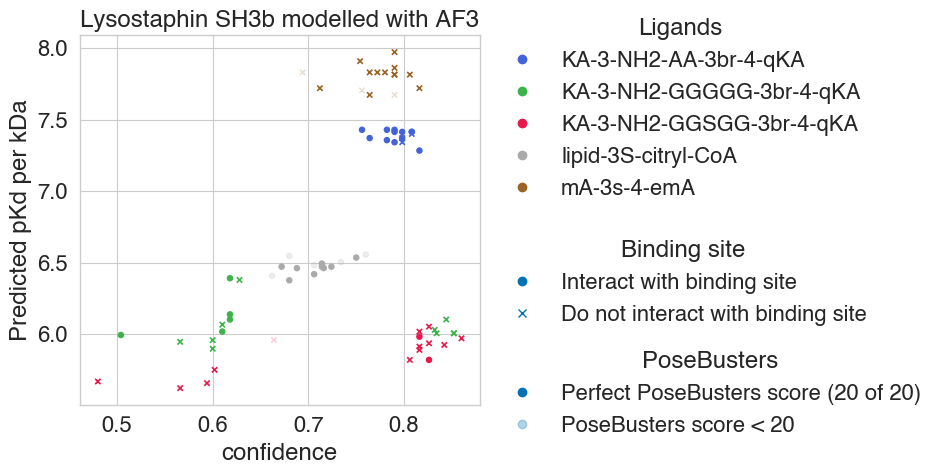

In [67]:
ax = plot_confidence_vs_pk(af3_results_all);
ax.set_title('Lysostaphin SH3b modelled with AF3');

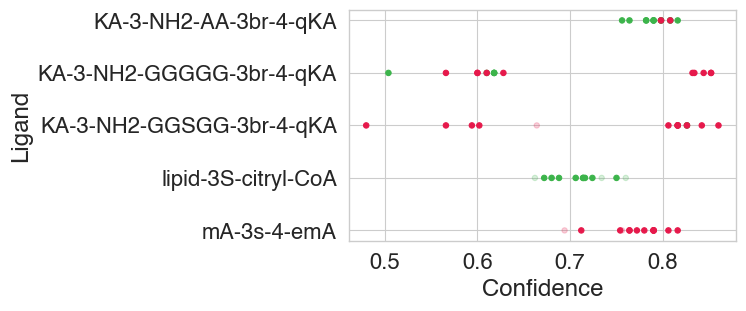

In [74]:
ax = plot_confidence(af3_results_all, no_fluff=False);
# plt.gcf().savefig('/Users/rs1521/Documents/01_Fellowship/figures/parts/Lysostaphin_AF3.pdf', dpi=300, bbox_inches='tight')

### Boltz

In [36]:
boltz_results_all = parse_results(data_folder / 'modelling' / 'boltz' / 'scores.csv')
boltz_results = sort_and_drop_duplicates(boltz_results_all)
boltz_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
mA-3s-4-emA,Lysostaphin_P10547_SH3b_413_493,510,2,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.859720,0.674538,0.712,20,9.9,NaN,5.14,8.116255,False
KA-3-NH2-GGGGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,763,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.830767,0.632612,0.672,20,8.3,NaN,5.02,6.052272,True
KA-3-NH2-GGSGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,510,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.785058,0.545333,0.593,20,7.3,NaN,5.04,5.864207,True
lipid-3S-citryl-CoA,Lysostaphin_P10547_SH3b_413_493,510,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.757148,0.521175,0.568,20,5.1,NaN,6.13,6.513435,False
KA-3-NH2-AA-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,318,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.758850,0.411586,0.481,20,6.7,NaN,5.18,7.546537,False


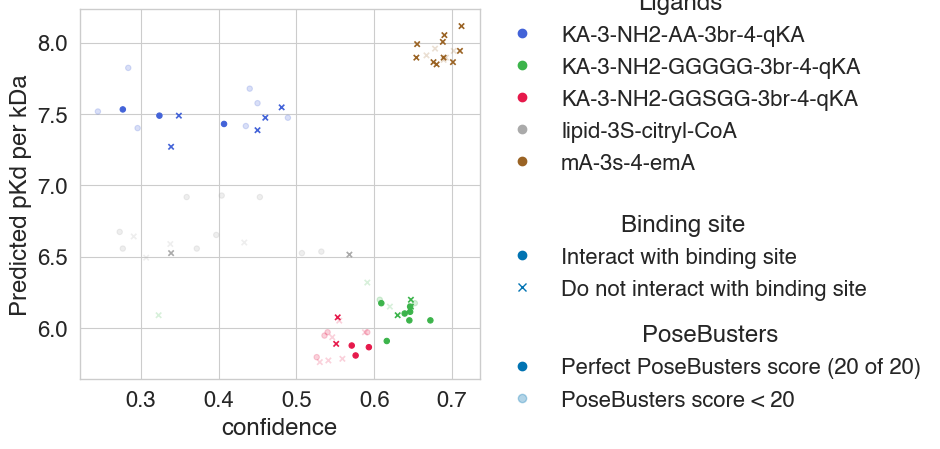

In [54]:
ax = plot_confidence_vs_pk(boltz_results_all);

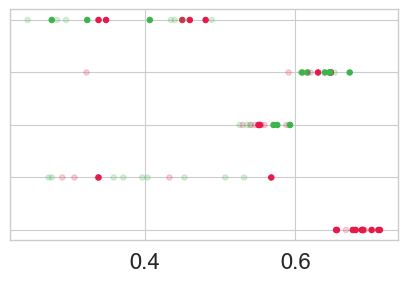

In [57]:
ax = plot_confidence(boltz_results_all, no_fluff=True);
plt.gcf().savefig('/Users/rs1521/Documents/01_Fellowship/figures/parts/Lysostaphin_Boltz.pdf', dpi=300, bbox_inches='tight')

### Chai

In [39]:
chai_results_all = parse_results(data_folder / 'modelling' / 'chai' / 'scores.csv')
chai_results = sort_and_drop_duplicates(chai_results_all)
chai_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
lipid-3S-citryl-CoA,Lysostaphin_P10547_SH3b_413_493,776,3,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.883407,0.674281,0.716,20,5.6,NaN,6.12,6.502810,True
mA-3s-4-emA,Lysostaphin_P10547_SH3b_413_493,687,3,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.899853,0.630862,0.685,20,7.2,NaN,4.96,7.832029,True
KA-3-NH2-GGGGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,411,4,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.811455,0.465776,0.535,20,3.1,NaN,4.95,5.967878,True
KA-3-NH2-GGSGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,411,3,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.785171,0.409901,0.485,20,5.0,NaN,5.11,5.945655,False
KA-3-NH2-AA-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,411,2,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.814335,0.398552,0.482,20,3.1,NaN,4.93,7.182322,True


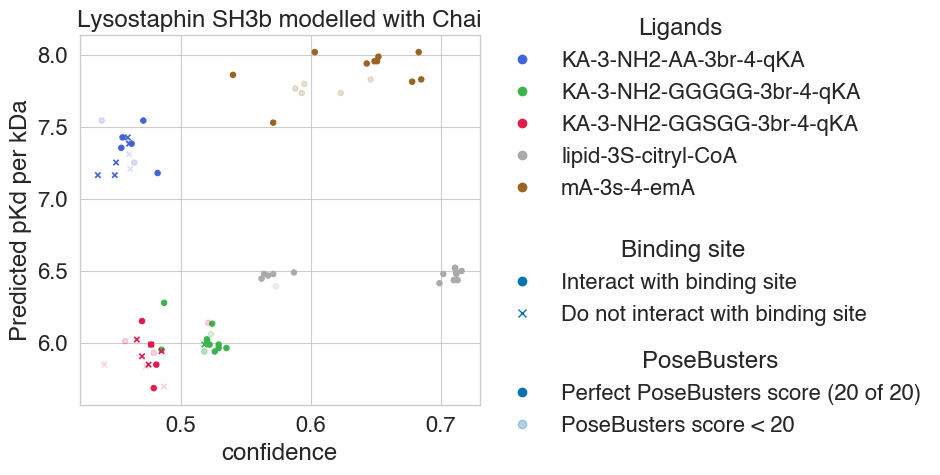

In [40]:
ax = plot_confidence_vs_pk(chai_results_all);
ax.set_title('Lysostaphin SH3b modelled with Chai');

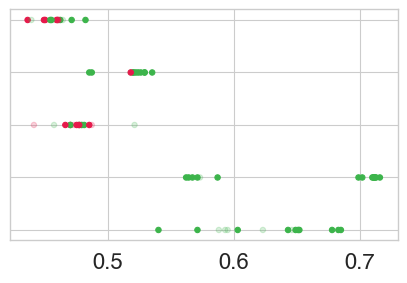

In [60]:
ax = plot_confidence(chai_results_all, no_fluff=True);
plt.gcf().savefig('/Users/rs1521/Documents/01_Fellowship/figures/parts/Lysostaphin_Chai.pdf', dpi=300, bbox_inches='tight')

### Protenix

In [42]:
protenix_results_all = parse_results(data_folder / 'modelling' / 'protenix' / 'scores.csv')
protenix_results = sort_and_drop_duplicates(protenix_results_all)
protenix_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
mA-3s-4-emA,Lysostaphin_P10547_SH3b_413_493,323,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.977853,0.963242,0.966,20,14.8,NaN,4.90,7.737286,False
KA-3-NH2-AA-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,944,3,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.968957,0.940900,0.947,20,10.8,NaN,4.96,7.226028,False
KA-3-NH2-GGSGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,185,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.958490,0.922738,0.930,20,4.4,NaN,4.96,5.771125,False
KA-3-NH2-GGGGG-3br-4-qKA,Lysostaphin_P10547_SH3b_413_493,323,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.950813,0.901985,0.912,20,4.2,NaN,4.84,5.835258,False
lipid-3S-citryl-CoA,Lysostaphin_P10547_SH3b_413_493,185,0,/gpfs/home/rs1521/PG/Lysostaphin_P10547/modell...,0.946691,0.895257,0.906,20,4.2,NaN,6.01,6.385929,False


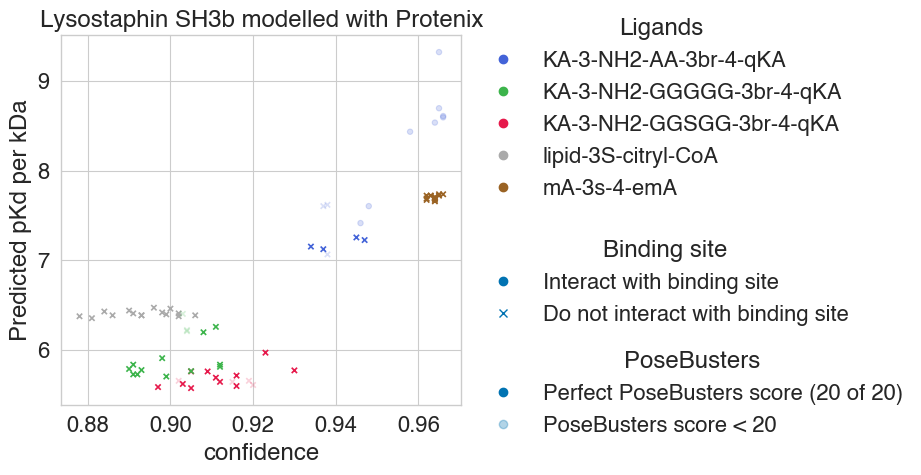

In [43]:
ax = plot_confidence_vs_pk(protenix_results_all);
ax.set_title('Lysostaphin SH3b modelled with Protenix');

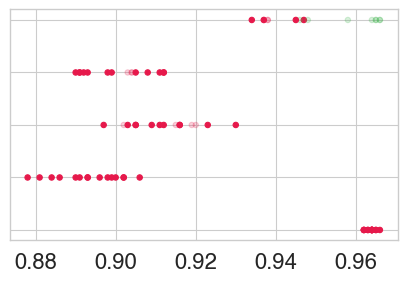

In [73]:
ax = plot_confidence(protenix_results_all, no_fluff=True);
plt.gcf().savefig('/Users/rs1521/Documents/01_Fellowship/figures/parts/Lysostaphin_Protenix.pdf', dpi=300, bbox_inches='tight')